# Regeneration

___
Import the required libraries.
___

In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB and branch == "stable":
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import loompy

Global seed set to 0


___
Set the filepath to store the results.
___

In [5]:
results_folder = '/data/xy/Spatial_transcriptome/eWEIDE/20231228_Regeneration/cell2location/result/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = '/data/xy/Spatial_transcriptome/eWEIDE/20231228_Regeneration/cell2location/reference_signatures'
run_name = f'{results_folder}cell2location_map'

raw_data_path = f'/data/xy/Spatial_transcriptome/eWEIDE/20231228_Regeneration/scanpy_data/'

data_name = 'Reg'

Spatial transcriptome data preprocess.

In [6]:
# adata_vis = sc.read_visium(image_path)
# adata_vis
adata_vis = sc.read_h5ad(f"{raw_data_path}/{data_name}_scanpy_Spatial.h5ad")
adata_vis

AnnData object with n_obs × n_vars = 2225 × 32285
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'slide', 'sample_detail', 'sample', 'mice', 'integrated_snn_res.0.8', 'integrated_snn_res.0.9', 'spot_id', 'Day', 'Monocyte', 'Anti.inflammatory.Mac', 'Spp1..Mac', 'MHCII..Mac', 'Pro.fibrotic.Mac', 'Dendritic.cell', 'Neutrophil', 'T.cell', 'B.cell', 'Basophil', 'Mast.cell', 'Inflammatory.fibro', 'ECM.remodeling.fibro', 'Lesion.induced.myofibro', 'ECM.remodeling.myofibro', 'Chondrocyte', 'Keratinocyte', 'Perivascular.cell', 'Endothelial.cell', 'Satellite.cell', 'ST2_tag', 'peri_core', 'row', 'col', 'eWEIDE_snn_res.0.1', 'eWEIDE_snn_res.0.2', 'eWEIDE_snn_res.0.3', 'eWEIDE_snn_res.0.4', 'eWEIDE_snn_res.0.5', 'eWEIDE_snn_res.0.6', 'eWEIDE_snn_res.0.7', 'eWEIDE_snn_res.0.8', 'eWEIDE_snn_res.0.9', 'eWEIDE_snn_res.1', 'eWEIDE_snn_res.1.1', 'eWEIDE_snn_res.1.2', 'eWEIDE_snn_res.1.3', 'eWEIDE_snn_res.1.4', 'eWEIDE_snn_

In [7]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

In [8]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Single cell data process

In [9]:
adata_ref = sc.read_loom(f"{raw_data_path}sc.Reg.loom", sparse=True, cleanup=False, X_name='spliced', obs_names='CellID', var_names='Gene', dtype='float32')

In [10]:
obs_ref= pd.read_csv(f'{raw_data_path}sc.Reg_meta.data.csv',delimiter=',', index_col=0)
adata_ref.obs = obs_ref
var_ref= pd.read_csv(f'{raw_data_path}sc.Reg_meta.features.csv',delimiter=',', index_col=0)
adata_ref.var = var_ref
adata_ref.write(f'{raw_data_path}sc.Reg.h5ad')

In [11]:
adata_ref

AnnData object with n_obs × n_vars = 18574 × 19623
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.4', 'integrated_snn_res.0.3', 'cluster_21', 'cell', 'doublet', 'Major_class', 'Minor_class', 'integrated_snn_res.0.1', 'integrated_snn_res.0.2', 'integrated_snn_res.0.6', 'integrated_snn_res.0.7', 'integrated_snn_res.0.8', 'integrated_snn_res.0.9', 'integrated_snn_res.1', 'integrated_snn_res.1.1', 'integrated_snn_res.1.2', 'integrated_snn_res.1.3', 'integrated_snn_res.1.4', 'integrated_snn_res.1.5', 'integrated_snn_res.1.6', 'integrated_snn_res.1.7', 'integrated_snn_res.1.8', 'integrated_snn_res.1.9', 'integrated_snn_res.2', 'Minor_class_reduction', 'integrated_snn_res.100', 'integrated_snn_res.200', 'Meta_cell'
    var: 'GeneID-2', 'SYMBOL'
    layers: 'counts', 'scale.data'

In [12]:
# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_ref.var['SYMBOL'] = adata_ref.var.index
adata_ref.var.index = adata_ref.var['GeneID-2'].copy()
adata_ref.var_names = adata_ref.var['GeneID-2'].copy()
adata_ref.var.index.name = None
# adata_ref.raw.var['SYMBOL'] = adata_ref.raw.var.index
# adata_ref.raw.var.index = adata_ref.raw.var['GeneID-2'].copy()
# adata_ref.raw.var.index.name = None

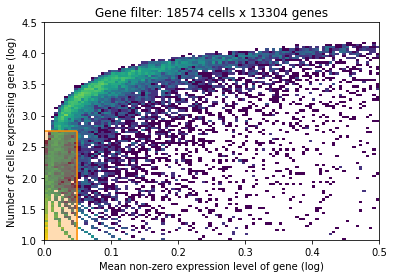

In [13]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [14]:
adata_ref.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,integrated_snn_res.0.5,seurat_clusters,integrated_snn_res.0.4,integrated_snn_res.0.3,cluster_21,cell,...,integrated_snn_res.1.5,integrated_snn_res.1.6,integrated_snn_res.1.7,integrated_snn_res.1.8,integrated_snn_res.1.9,integrated_snn_res.2,Minor_class_reduction,integrated_snn_res.100,integrated_snn_res.200,Meta_cell
AAACCCAAGATCCCAT_1,MRL_D7,5656,2173,9.282178,2,604,4,4,3,AAACCCAAGATCCCAT,...,10,9,10,10,11,9,Anti-inflammatory Mac,304,604,Meta cell_604
AAACCCAAGTCTGGTT_1,MRL_D7,8100,2708,7.456790,2,1254,4,4,3,AAACCCAAGTCTGGTT,...,10,9,10,10,11,9,Anti-inflammatory Mac,234,1254,Meta cell_1254
AAACCCACACATTACG_1,MRL_D7,5274,1918,10.807736,2,658,4,4,3,AAACCCACACATTACG,...,2,3,2,2,0,0,Spp1+ Mac,397,658,Meta cell_658
AAACGCTCACTATGTG_1,MRL_D7,5291,2006,4.554905,2,882,4,4,3,AAACGCTCACTATGTG,...,2,3,2,2,0,0,Spp1+ Mac,508,882,Meta cell_882
AAACGCTGTCGCTTGG_1,MRL_D7,11850,3044,5.468354,2,1330,4,4,3,AAACGCTGTCGCTTGG,...,10,9,10,10,0,9,Spp1+ Mac,398,1330,Meta cell_1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATTTCAGGGATCAC_2,WT_D7,1677,796,7.632677,20,66,9,2,21,TGATTTCAGGGATCAC,...,14,14,29,37,32,32,B cell,348,66,Meta cell_66
TGCTCGTGTATGAGGC_2,WT_D7,3264,1221,7.720588,20,66,9,2,21,TGCTCGTGTATGAGGC,...,14,14,29,37,32,32,B cell,348,66,Meta cell_66
TGGATGTGTGTAGCAG_2,WT_D7,2104,856,6.178707,20,66,9,2,21,TGGATGTGTGTAGCAG,...,14,14,29,37,32,32,B cell,348,66,Meta cell_66
TGTGATGCAGGTATGG_2,WT_D7,1942,912,8.084449,20,66,9,2,21,TGTGATGCAGGTATGG,...,14,14,29,37,32,32,B cell,348,66,Meta cell_66


In [15]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                                                           # 10X reaction / sample / batch
                                                           batch_key='orig.ident',               
                                                           # cell type, covariate used for constructing signatures
                                                           labels_key='Minor_class_reduction',
                                                           # multiplicative technical effects (platform, 3' vs 5', donor effect)
                                                           categorical_covariate_keys=['orig.ident']
                                                          )

Anndata setup with scvi-tools version 0.16.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'Minor_class_reduction',
│   'categorical_covariate_keys': ['orig.ident'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 18574 │
│          n_vars          │ 13304 │
│         n_batch          │   2   │
│         n_labels         │  20   │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│         labels         │         adata.obs['_scvi_labels']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   MRL_D7   │          0          │
│                         │   WT_D7    │          1          │
└─────────────────────────┴────────────┴─────────────────────┘

                                labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃          Source Location           ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Minor_class_reduction'] │  Anti-inflammatory Mac  │          0          │
│                                    │         B cell          │          1          │
│                                    │        Basophil         │          2          │
│                                    │       Chondrocyte       │          3          │
│                                    │     Dendritic cell      │          4          │
│                                    │  ECM-remodeling fibro   │          5          │
│                                    │ ECM-remodeling myofibro │          6          │
│                                    │    Endothelial cell     │          7          │
│                                    │   Inflammatory fibro    │          8          │
│                                    │      Keratinocyte       │          9          │
│                                    │ Lesion-induced myofibro │         10          │
│                                    │       MHCII+ Mac        │         11          │
│                                    │        Mast cell        │         12          │
│                                    │        Monocyte         │         13          │
│                                    │       Neutrophil        │         14          │
│                                    │    Perivascular cell    │         15          │
│                                    │    Pro-fibrotic Mac     │         16          │
│                                    │     Satellite cell      │         17          │
│                                    │        Spp1+ Mac        │         18          │
│                                    │         T cell          │         19          │
└────────────────────────────────────┴─────────────────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   MRL_D7   │          0          │
│                         │   WT_D7    │          1          │
│                         │            │                     │
└─────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1000/1000: 100%|██████████| 1000/1000 [33:33<00:00,  2.01s/it, v_num=1, elbo_train=1.35e+8]


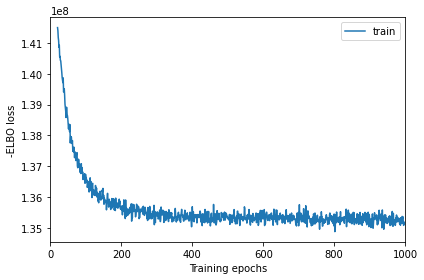

In [16]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(train_size=1,batch_size=2500, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [17]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 65.33it/s]


'/data/xy/Spatial_transcriptome/eWEIDE/20231228_Regeneration/cell2location/reference_signatures/sc.h5ad'

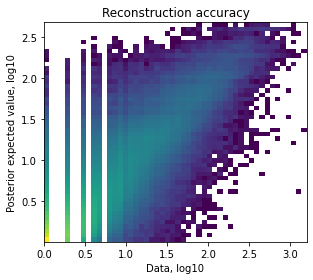

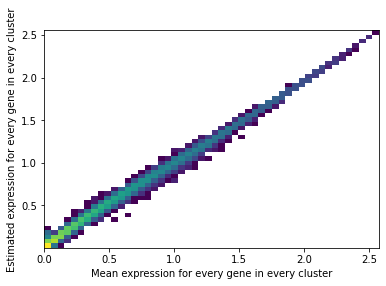

In [18]:
mod.plot_QC()

In [19]:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Anti-inflammatory Mac,B cell,Basophil,Chondrocyte,Dendritic cell
Sox17,0.002058,0.047243,0.006717,0.000893,0.001333
Mrpl15,0.551620,0.186089,0.135567,0.438846,0.529378
Lypla1,0.465267,0.107644,0.129711,0.238006,0.415028
Tcea1,0.530267,0.123769,0.112247,0.488479,0.544661
Atp6v1h,0.891819,0.101107,0.105102,0.347569,0.450994


In [20]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis.var_names = adata_vis.var['SYMBOL'].copy()
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
intersect

/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


array(['0610005C13Rik', '0610009B22Rik', '0610010F05Rik', ..., 'mt-Nd4l',
       'mt-Nd5', 'mt-Nd6'], dtype=object)

In [21]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
intersect
adata_vis[:, intersect]


View of AnnData object with n_obs × n_vars = 2225 × 13096
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'slide', 'sample_detail', 'sample', 'mice', 'integrated_snn_res.0.8', 'integrated_snn_res.0.9', 'spot_id', 'Day', 'Monocyte', 'Anti.inflammatory.Mac', 'Spp1..Mac', 'MHCII..Mac', 'Pro.fibrotic.Mac', 'Dendritic.cell', 'Neutrophil', 'T.cell', 'B.cell', 'Basophil', 'Mast.cell', 'Inflammatory.fibro', 'ECM.remodeling.fibro', 'Lesion.induced.myofibro', 'ECM.remodeling.myofibro', 'Chondrocyte', 'Keratinocyte', 'Perivascular.cell', 'Endothelial.cell', 'Satellite.cell', 'ST2_tag', 'peri_core', 'row', 'col', 'eWEIDE_snn_res.0.1', 'eWEIDE_snn_res.0.2', 'eWEIDE_snn_res.0.3', 'eWEIDE_snn_res.0.4', 'eWEIDE_snn_res.0.5', 'eWEIDE_snn_res.0.6', 'eWEIDE_snn_res.0.7', 'eWEIDE_snn_res.0.8', 'eWEIDE_snn_res.0.9', 'eWEIDE_snn_res.1', 'eWEIDE_snn_res.1.1', 'eWEIDE_snn_res.1.2', 'eWEIDE_snn_res.1.3', 'eWEIDE_snn_res.1.4', 'eWE

In [22]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [23]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2225  │
│          n_vars          │ 13096 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    Reg     │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|██████████| 30000/30000 [48:01<00:00, 10.41it/s, v_num=1, elbo_train=1.69e+7]


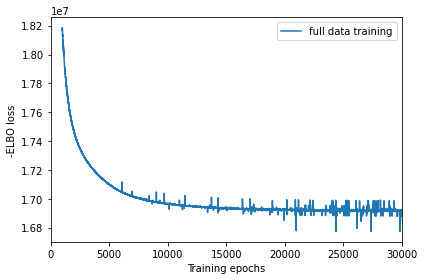

In [24]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [25]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:21<00:00, 46.02it/s]


'/data/xy/Spatial_transcriptome/eWEIDE/20231228_Regeneration/cell2location/result/cell2location_map/sp.h5ad'

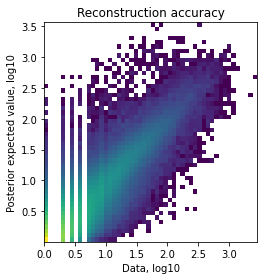

In [26]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [27]:
adata_vis.obs

,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,slide,sample_detail,sample,...,eWEIDE_snn_res.1.2,eWEIDE_snn_res.1.3,eWEIDE_snn_res.1.4,eWEIDE_snn_res.1.5,in_tissue,array_row,array_col,_indices,_scvi_batch,_scvi_labels
AAACATTTCCCGGATT-1_1,A012701,4109.0,2072,5652.0,2069,4,0,A1,MRL_D15,Reg,...,0,0,0,0,1.0,6.000000,-117.000000,0,0,0
AAACCGGGTAGGTACC-1_1,A012701,7542.0,3173,7034.0,3170,7,1,A1,MRL_D0,Reg,...,2,2,1,1,1.0,35.000000,2.000000,1,0,0
AAACCTCATGAAGTTG-1_1,A012701,6997.0,2659,6751.0,2655,6,5,A1,B6_D0,Reg,...,7,7,6,5,1.0,40.000000,1.000000,2,0,0
AAACGCCCGAGATCGG-1_1,A012701,4428.0,2391,5637.0,2393,1,4,A1,MRL_D15,Reg,...,4,5,4,4,1.0,63.000000,-128.000000,3,0,0
AAACGGGTTGGTATCC-1_1,A012701,3981.0,1891,5650.0,1898,5,1,A1,B6_D0,Reg,...,2,2,1,1,1.0,76.000000,-3.000000,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTACACCTCGAACA-1_2,B012602,7260.0,3102,5397.0,3052,3,6,B2,B6_D10_proximal,Reg,...,6,1,5,6,1.0,0.606299,-83.597403,2220,0,0
TTGTGAGGCATGACGC-1_2,B012602,3916.0,1939,4149.0,1938,3,9,B2,MRL_D10_proximal,Reg,...,9,9,9,9,1.0,7.881890,-86.896104,2221,0,0
TTGTGGTAGGAGGGAT-1_2,B012602,3621.0,1865,4045.0,1858,1,2,B2,B6_D10_proximal,Reg,...,1,3,2,2,1.0,16.976378,-81.948052,2222,0,0
TTGTTAGCAAATTCGA-1_2,B012602,857.0,609,3292.0,992,1,11,B2,MRL_D3_proximal,Reg,...,10,10,10,11,1.0,25.464567,-21.285714,2223,0,0


In [28]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
outdf = adata_vis.obs[adata_vis.uns['mod']['factor_names']]
outdf.to_csv(f"{results_folder}{data_name}_C2L.csv")